In [1]:
import re
import json
import requests
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler,
    RobustScaler,
    Normalizer)
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression, 
    LogisticRegressionCV, 
    PoissonRegressor, 
    TweedieRegressor,
    PassiveAggressiveClassifier,
    RidgeClassifierCV)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.pipeline import make_pipeline
from IPython.display import display
pd.options.display.max_columns = None
import warnings
warnings.simplefilter('ignore')

# **WARNING** 

### We are dealing with raw web data. Some of the information that is retrieved might contain certain explicit content (words, phrases, or references)

# Data Engineering - NLP

## Exercise 1: NLP Tweets

For this exercise, use TfidfVectorizer and any TWO classification models you would like to correctly identify the sentiments of each review, in the Restaurant_Reviews.tsv file, as (Positive, or Negative). 

### Remember:
    1. Split your data into Train and Test sets
    2. Evaluate your model using the metrics of your choice (include a brief interpretation)
    3. Explain which model performed better and why (comparison of results)

In [2]:
#Exercise 1
df = pd.read_csv('../data/Restaurant_Reviews.tsv', sep='\t')

X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Liked'], test_size=0.2, random_state=10)

In [3]:
# using the tfidf vectorizer for vectorizing and transforming
tf = TfidfVectorizer()

X_train = tf.fit_transform(X_train)
X_test = tf.transform(X_test)



Classification report
-------------------
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       100
           1       0.81      0.81      0.81       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200

-------------------
Log Loss Mean: 0.52
Log Loss Total: 104.35
-------------------


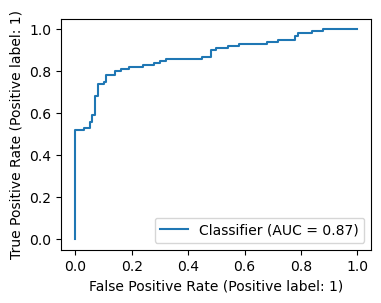

In [4]:
# perform basic logistic regression, fit, and predict
logit = LogisticRegression()
logit.fit(X_train,y_train)           
y_pred = logit.predict(X_test)

# evaluation metrics
print(f'\nClassification report\n-------------------\n'
      f'{metrics.classification_report(y_test, y_pred)}\n'
      f'-------------------')

print(f'Log Loss Mean: {metrics.log_loss(y_test, logit.predict_proba(X_test)):.2f}')
print(f'Log Loss Total: {metrics.log_loss(y_test, logit.predict_proba(X_test), normalize=False):.2f}\n-------------------')

fig, (ax1) = plt.subplots(1, 1, figsize=(4,3))
metrics.RocCurveDisplay.from_predictions(y_test, logit.decision_function(X_test), ax=ax1)
plt.show()


### Interpretation

The basic logistic regression has classified with 81% in everything which is interesting. So 81% of the reviews were classified correctly. Since this is a balanced and binary classification, I used the log loss as another metric which shows that the mean log loss is not that much below 0.69, the non-informative value, so could probably be further optimized. I also wanted to look at the AUC, which is 0.87, in order to compare models.


Classification report
-------------------
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       100
           1       0.85      0.83      0.84       100

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200

-------------------
Log Loss Mean: 0.43
Log Loss Total: 86.61
-------------------


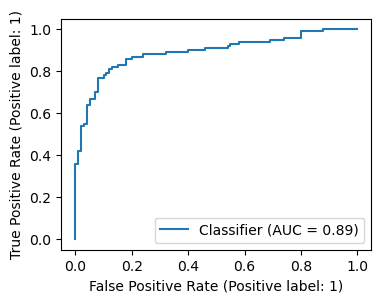

In [5]:
# perform SVM, fit, and predict
svc = SVC(C=2, probability=True, random_state=10)
svc.fit(X_train,y_train)           
y_pred = svc.predict(X_test)

# evaluation metrics
print(f'\nClassification report\n-------------------\n'
      f'{metrics.classification_report(y_test, y_pred)}\n'
      f'-------------------')

print(f'Log Loss Mean: {metrics.log_loss(y_test, svc.predict_proba(X_test)):.2f}')
print(f'Log Loss Total: {metrics.log_loss(y_test, svc.predict_proba(X_test), normalize=False):.2f}\n-------------------')

fig, (ax1) = plt.subplots(1, 1, figsize=(4,3))
metrics.RocCurveDisplay.from_predictions(y_test, svc.decision_function(X_test), ax=ax1)
plt.show()


### Interpretation and Comparison

Metrics are slighly better here but are still not great. I decided to compare between vanilla logistic regression and a support vector machine model. There is an improvement in model performance with the SVM but it might still be possible to optimize further with a hyperparameter search. I tried other models, such as random forest, multinomial naive bayes, and a grid search of parameters with logitstic regression but the SVM performed best. I am thinking that all the metrics performed better for SVM because SVM was able to find a hyperspace that allowed for greater separation of positive and negative reviews. The AUC is only slightly higher here but still indicates that this is a better model. F1 and accuracy are 83% for everything which is two points higher than the logistic model, meaning this SVM correctly classifies 2% more data. The log loss for SVM is a bit lower as well, showing that the error in choosing a classification is better here.


## Exercise 2: App Review NLP work (Similar to Web Data workshop)

The Apple app store has a `GET` API to get reviews on apps. The URL is:

```
https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json
```

Note that you need to provide:

- The country codes (`'us'`, `'gb'`, `'ca'`, `'au'`) - use all four
- The app ID. This can be found in the web page for the app right after `id`.
    - You will need to find the IDs for these apps - Candy Crush, Facebook, Twitter & Tinder
- The "Page Number". The request responds with multiple pages of data, but sends them one at a time. So you can cycle through the data pages for any app on any country. (Be careful, there are limits to the number of pages you can access)

For example, Candy Crush's US webpage is `https://apps.apple.com/us/app/candy-crush-saga/id553834731`, which means that the ID is `553834731`.


Do the following:

1. Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)
1. Do the same as 1.1, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.

ps. Feel free to do as much data engineering to boost your model. (ie binary vs multinomial)


In [6]:
# exercise 2

COUNTRY_CODE = ['us', 'gb', 'ca', 'au']
APP_IDS = {'Candy Crush': '553834731', 'Facebook': '284882215', 'Twitter': '333903271', 'Tinder': '547702041'}

# list to store page data
json_list = []

# loop over pages to build a list of dictionaries
for CODE in COUNTRY_CODE:
    for APP, ID in APP_IDS.items():
        for PAGE_NUMBER in range(1, 11):
            r = requests.get(f'https://itunes.apple.com/{CODE}/rss/customerreviews/id={ID}/page={PAGE_NUMBER}/sortby=mostrecent/json')
            feed = r.json()['feed']
            feed.update({'app': APP})
            json_list.append(feed)
            

In [7]:
# create a table that has a column for each section of the dictionary-like json
df = pd.DataFrame(json_list).explode('entry')
# turn the table of dictionaries into a dataframe with individual values for each row/column
df = pd.json_normalize(json.loads(df.to_json(orient='records')))
# keep only the relevant columns
df = df[['app', 'entry.im:version.label', 'entry.title.label', 'entry.content.label', 'entry.im:rating.label']]
# rename columns for ease
df = df.rename(columns = {'entry.im:version.label': 'version', 
           'entry.title.label': 'title', 
           'entry.content.label': 'review', 
           'entry.im:rating.label': 'rating'
           })
# one bad sample to drop
df.dropna(inplace=True)
# rating as int
df = df.astype({'rating': 'int32'})

df.sample(5)

,app,version,title,review,rating
6548,Facebook,403.1,Everything is bad,"Facebook prioritises sponsored content, so you...",1
1941,Tinder,14.2.0,Too many bots,Too many bots,1
5371,Twitter,9.40,past few months,"Twitter has always been great, and has had som...",1
2510,Facebook,405.1,lag scrolling,Facebook is the only app on my phone thats con...,1
1613,Tinder,14.3.0,It dosent work,The amount of time I spent on this app and hav...,1


In [8]:
# concatenate the title and review for use in nlp and clean up the strings to remove emoji and odd characters
# this version keeps non-english characters since they somehow improved the performance of the model
df['combined_text'] = df.title + ' ' + df.review
df['combined_text'] = df['combined_text'].str.replace(r'[^ \w+]', '', regex=True)
df['combined_text'] = df['combined_text'].str.strip().str.replace('\n', '').str.replace('\s+', ' ', regex=True)
df['combined_text'][0]

'Satisfying fun Its pretty easy the vibrations are so satisfying on each level It might be hard but once you get used to it its SUPERRRRRR FUNNN Def recommended for 8yr olds up'

In [9]:
# make the training and testing sets
# using only the combined text was giving the best results after trying to use app and version as categorical
X = df['combined_text']
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [10]:
# load spacy and make a tokenizer for TfidfVectorizer (found on SO, not sure it's doing what I think it is)
nlp = spacy.load("en_core_web_sm")

class LemmaTokenizer(object):
    def __call__(self, doc):
        nlpdoc = nlp(doc)
        nlpdoc = [token.lemma_ for token in nlpdoc if (len(token.lemma_) > 1) or (token.lemma_.isalnum()) ]
        return nlpdoc

In [11]:
# create a tfidf pipeline to vectorize and reduce dimensions
tfidf = make_pipeline(TfidfVectorizer(stop_words='english', strip_accents='unicode', tokenizer=LemmaTokenizer()),
                        TruncatedSVD(n_components=2000, n_iter=7, random_state=10))

In [12]:
# use the tfidf pipeline to fit and transform on the train data and just transform the test data
X_transformed = tfidf.fit_transform(X_train)

X_test_transformed = tfidf.transform(X_test)

In [53]:
# simple linear regression that is collapsed into the 5 star classification
reg_model = LinearRegression()

X_fit = reg_model.fit(X_transformed, y_train)

y_pred = reg_model.predict(X_test_transformed)

y_pred_ = pd.cut(pd.DataFrame(y_pred)[0], bins=np.linspace(y_pred.min(), y_pred.max(), 6), labels=[1,2,3,4,5],
                 include_lowest=True).to_numpy().astype(int)

print(f'MSE: {metrics.mean_squared_error(y_test, y_pred_):.3f}\n---------------')
print(f'Classification Report\n{metrics.classification_report(y_test, y_pred_)}')


MSE: 1.621
---------------
Classification Report
              precision    recall  f1-score   support

           1       0.92      0.15      0.25       995
           2       0.11      0.68      0.19       145
           3       0.11      0.36      0.17       116
           4       0.05      0.12      0.07        57
           5       0.90      0.12      0.21       287

    accuracy                           0.20      1600
   macro avg       0.42      0.29      0.18      1600
weighted avg       0.75      0.20      0.23      1600



<font color='red'>Accuracy is not good at all. The MSE is better than the logistic regression, but only for this run, it was worse before. The results are quite variable depending on what data comes in from the web scraping. Compressing the linear data into the classification of 1-5 may not be the right way to get metrics but I am not sure how else to do it. </font>

In [54]:
# the classification model will be cross validated logistic regression
clf_model = LogisticRegressionCV(multi_class='multinomial')

X_fit_c = clf_model.fit(X_transformed, y_train)

y_pred_c = clf_model.predict(X_test_transformed)

print(f'MSE: {metrics.mean_squared_error(y_test, y_pred_c):.3f}\n---------------')
print(f'Classification Report\n{metrics.classification_report(y_test, y_pred_c)}')


MSE: 1.705
---------------
Classification Report
              precision    recall  f1-score   support

           1       0.74      0.95      0.83       995
           2       0.17      0.05      0.08       145
           3       0.24      0.05      0.09       116
           4       0.12      0.02      0.03        57
           5       0.78      0.68      0.73       287

    accuracy                           0.72      1600
   macro avg       0.41      0.35      0.35      1600
weighted avg       0.64      0.72      0.66      1600



<font color='red'>The MSE is worse than linear regression for this run. The precision of the logistic regression model looks ok but the recall is very poor for catching true positives. Looking at it further the model is primarily predicting 1s and 5s. There is also a heavy imbalance in the number of each of the ratings which can skew the models performance. But 72% accuracy is still better than the linear regression.</font>

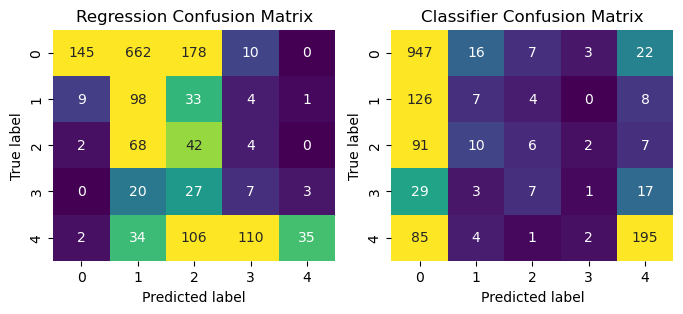

In [56]:
# plot confusion matrices to compare
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))

sns.heatmap(metrics.confusion_matrix(y_test, y_pred_), cmap='viridis', vmax=50, annot=True, fmt="d", ax=ax1, cbar=False)
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')
ax1.set_title('Regression Confusion Matrix')

sns.heatmap(metrics.confusion_matrix(y_test, y_pred_c), cmap='viridis', vmax=50, annot=True, fmt="d", ax=ax2, cbar=False)
ax2.set_xlabel('Predicted label')
ax2.set_ylabel('True label')
ax2.set_title('Classifier Confusion Matrix')

plt.show()

<font color='red'>The linear regression confusion matrix makes it obvious that the compression of the continuous data pushed a lot of 1s and 2s as predictions. The classifier predicted mostly 0s, but this is likely because of the skew in number of samples. I can't really say that one performed well, but I would say that it makse much more sense to use a classification model for an ordinal y. </font>